# Stock Predictor

Based on the Anna KaRNNa RNN example, we'll try to model a stock price predictor to fix the RNN concept.

In [1]:
import time
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import namedtuple
%matplotlib inline

try:
    from yahoo_finance import Share
except:
    !pip install yahoo-finance
    from yahoo_finance import Share
    
print('All loaded')

All loaded


## Load data

In [2]:
stock = Share('GOOG')
stock_data = stock.get_historical('2007-01-01', '2017-02-28')
stock_data = json.dumps(stock_data)
stock_data = pd.read_json(stock_data)
print(stock_data.head())

    Adj_Close       Close       Date        High         Low        Open  \
0  823.210022  823.210022 2017-02-28  828.539978  820.200012  825.609985   
1  829.280029  829.280029 2017-02-27  830.500000  824.000000  824.549988   
2  828.640015  828.640015 2017-02-24  829.000000  824.200012  827.729980   
3  831.330017  831.330017 2017-02-23  832.460022  822.880005  830.119995   
4  830.760010  830.760010 2017-02-22  833.250000  828.640015  828.659973   

  Symbol   Volume  
0   GOOG  2252300  
1   GOOG  1099500  
2   GOOG  1386600  
3   GOOG  1470100  
4   GOOG   982900  


In [3]:
stock_data = stock_data.sort_values('Date')
print(stock_data.head())
prices = stock_data['Adj_Close'].values

       Adj_Close       Close       Date        High         Low        Open  \
2556  233.561839  467.590802 2007-01-03  476.660820  461.110782  466.000786   
2555  241.389023  483.260825 2007-01-04  483.950842  468.350813  469.000793   
2554  243.352058  487.190821 2007-01-05  487.500848  478.110817  482.500814   
2553  241.548870  483.580838 2007-01-08  489.870847  482.200835  487.690827   
2552  242.507903  485.500822 2007-01-09  488.250842  481.200822  485.450830   

     Symbol    Volume  
2556   GOOG  15470700  
2555   GOOG  15834200  
2554   GOOG  13795600  
2553   GOOG   9544400  
2552   GOOG  10803000  


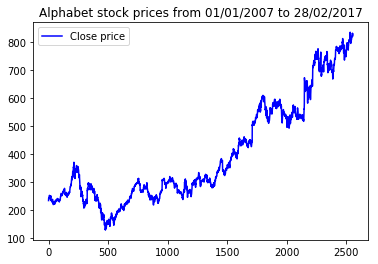

In [4]:
plt.plot(range(len(prices)), prices, color='blue', label='Close price')
plt.title('Alphabet stock prices from 01/01/2007 to 28/02/2017')
plt.legend()
plt.show()

## Preprocessing

In [111]:
returns = np.diff(np.log(prices))
returns = (returns - np.mean(returns)) / np.std(returns)
returns.shape

(2556,)

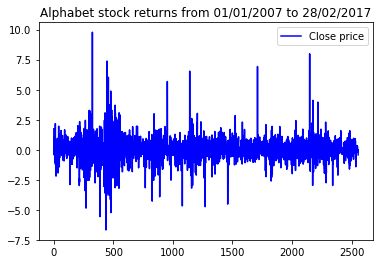

In [112]:
plt.plot(range(len(returns)), returns, color='blue', label='Close price')
plt.title('Alphabet stock returns from 01/01/2007 to 28/02/2017')
plt.legend()
plt.show()

In [113]:
def split_data(returns, batch_size, num_steps, split_frac=0.9):
    slice_size = batch_size * num_steps
    n_batches = int(len(returns) / slice_size)
    
    x = returns[-n_batches * slice_size -1:-1]
    y = returns[-n_batches * slice_size:]
    
    x = np.stack(np.split(x, batch_size))
    y = np.stack(np.split(y, batch_size))
    
    split_idx = int(n_batches * split_frac)
    train_x, train_y = x[:, :split_idx * num_steps], y[:, :split_idx * num_steps]
    val_x, val_y = x[:, split_idx * num_steps:], y[:, split_idx * num_steps:]
    return train_x, train_y, val_x, val_y

In [114]:
train_x, train_y, val_x, val_y = split_data(returns, 10, 50)

In [115]:
print(train_x.shape)
print(train_y.shape)

(10, 200)
(10, 200)


In [116]:
train_x[:,:5]

array([[ 0.34145147, -0.18638823, -0.22877645, -0.13842856, -0.34958385],
       [ 3.22441807, -1.1810728 ,  0.85052967, -1.70906233, -0.75824573],
       [-0.53924561,  0.00934313,  2.896927  , -0.24762771, -0.50898806],
       [ 0.00773795,  0.0533216 , -0.63778306, -0.26718904, -0.85296523],
       [-0.65698292, -0.06710854, -1.21634026,  0.3832506 , -0.05526761],
       [-0.64044022,  0.41081386,  1.0846083 , -0.18259789,  0.42047478],
       [ 0.18654265, -0.49310529, -0.17620875, -0.27279247, -0.5026598 ],
       [-0.23952086, -0.16928527, -0.54311316,  0.3001761 , -0.845397  ],
       [ 0.15705562, -0.74608529,  0.08376464, -1.35142254, -0.39900096],
       [-0.02352026, -0.50983103, -0.14215643, -1.23013183, -0.11867286]])

In [117]:
def get_batch(arrs, num_steps):
    batch_size, slice_size = arrs[0].shape
    n_batches = int(slice_size / num_steps)
    for b in range(n_batches):
        yield [x[:, b * num_steps:(b + 1) * num_steps] for x in arrs]

In [118]:
for i, x in enumerate(get_batch([train_x], 50)):
    if i < 1:
        print(x[0].shape)

(10, 50)


## Building the model

In [129]:
def my_rnn(num_classes=1, batch_size=50, num_steps=50, lstm_size=128, num_layers=2,
           learning_rate=0.001, grad_clip=5, sampling=False):
    
    if sampling:
        batch_size, num_steps = 1, 1
    
    tf.reset_default_graph()
    
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
    with tf.name_scope('inputs'):
        inputs = tf.placeholder(tf.float32, [batch_size, num_steps], name='inputs')
        rnn_inputs = [tf.reshape(i, [batch_size, 1], name='rnn_inputs') for i in tf.split(inputs, num_steps, 1)]
    
    with tf.name_scope('targets'):
        targets = tf.placeholder(tf.float32, [batch_size, num_steps], name='targets')
        targets_reshaped = tf.reshape(targets, [-1, num_classes], name='targets_reshaped')
    
    with tf.name_scope('RNN'):
        with tf.name_scope('cells'):
            lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
            drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
            cell = tf.contrib.rnn.MultiRNNCell([drop] * num_layers)
        with tf.name_scope('initial_state'):
            initial_state = cell.zero_state(batch_size, tf.float32)
        with tf.name_scope('foward'):
            outputs, state = tf.contrib.rnn.static_rnn(cell, rnn_inputs, initial_state=initial_state)
    
    final_state = state
            
    with tf.name_scope('seq_reshape'):
        seq_output = tf.concat(outputs, axis=1, name='seq_output')
        rnn_output = tf.reshape(seq_output, [-1, lstm_size], name='graph_output')
    
    with tf.name_scope('logits'):
        W = tf.Variable(tf.truncated_normal([lstm_size, num_classes]))
        b = tf.Variable(tf.zeros(num_classes))
        logits = tf.add(tf.matmul(rnn_output, W), b)
        tf.summary.histogram('W', W)
        tf.summary.histogram('b', b)
        tf.summary.histogram('logits', logits)
    
    with tf.name_scope('mse'):
        error = tf.subtract(logits, targets_reshaped)
        mse = tf.reduce_mean(tf.square(error))
        tf.summary.scalar('mse', mse)
    
    with tf.name_scope('train'):
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(mse, tvars), grad_clip)
        train_op = tf.train.AdamOptimizer(learning_rate)
        optimizer = train_op.apply_gradients(zip(grads, tvars))
        
    merged = tf.summary.merge_all()
    
    export_nodes = ['inputs', 'targets', 'targets_reshaped', 'rnn_inputs', 'initial_state', 'final_state',
                    'keep_prob', 'mse', 'logits', 'optimizer', 'merged', 'error']
    Graph = namedtuple('Graph', export_nodes)
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])
    
    return graph

## Hyperparameters

In [130]:
batch_size = 5
num_steps = 20
lstm_size = 32
num_layers = 2
learning_rate = 0.5
keep_prob = 0.5

## Training

In [132]:
epochs = 3
save_every_n = 100
train_x, train_y, val_x, val_y = split_data(returns, batch_size, num_steps)

model = my_rnn(1, batch_size=batch_size, num_steps=num_steps,
               learning_rate=learning_rate, lstm_size=lstm_size, num_layers=num_layers)

saver = tf.train.Saver(max_to_keep=100)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_writer = tf.summary.FileWriter('./logs/1/train', sess.graph)
    test_writer = tf.summary.FileWriter('./logs/1/test')
    
    # Use the line below to load a checkpoint and resume training
    #saver.restore(sess, 'checkpoints/anna20.ckpt')
    
    n_batches = int(train_x.shape[1]/num_steps)
    iterations = n_batches * epochs
    for e in range(epochs):
        
        # Train network
        new_state = sess.run(model.initial_state)
        loss = 0
        for b, (x, y) in enumerate(get_batch([train_x, train_y], num_steps), 1):
            iteration = e*n_batches + b
            start = time.time()
            feed = {model.inputs: x,
                    model.targets: y,
                    model.keep_prob: 0.5,
                    model.initial_state: new_state}
            summary, batch_loss, new_state, logits, _ = sess.run([model.merged, model.mse, 
                                                          model.final_state, model.logits, model.optimizer], 
                                                          feed_dict=feed)
            loss += batch_loss
            end = time.time()
            print('Epoch {}/{} '.format(e+1, epochs),
                  'Iteration {}/{}'.format(iteration, iterations),
                  'Training loss: {:.4f}'.format(loss/b),
                  '{:.4f} sec/batch'.format((end-start)))
            
            train_writer.add_summary(summary, iteration)
        
            if (iteration%save_every_n == 0) or (iteration == iterations):
                # Check performance, notice dropout has been set to 1
                val_loss = []
                new_state = sess.run(model.initial_state)
                for x, y in get_batch([val_x, val_y], num_steps):
                    feed = {model.inputs: x,
                            model.targets: y,
                            model.keep_prob: 1.,
                            model.initial_state: new_state}
                    summary, batch_loss, new_state = sess.run([model.merged, model.mse, 
                                                               model.final_state], feed_dict=feed)
                    val_loss.append(batch_loss)
                    
                test_writer.add_summary(summary, iteration)

                print('Validation loss:', np.mean(val_loss),
                      'Saving checkpoint!')
                #saver.save(sess, "checkpoints/anna/i{}_l{}_{:.3f}.ckpt".format(iteration, lstm_size, np.mean(val_loss)))

Epoch 1/3  Iteration 1/66 Training loss: 0.5725 0.4104 sec/batch
Epoch 1/3  Iteration 2/66 Training loss: 68.1393 0.0237 sec/batch
Epoch 1/3  Iteration 3/66 Training loss: 47.9728 0.0231 sec/batch
Epoch 1/3  Iteration 4/66 Training loss: 39.5165 0.0270 sec/batch
Epoch 1/3  Iteration 5/66 Training loss: 32.7737 0.0462 sec/batch
Epoch 1/3  Iteration 6/66 Training loss: 27.9026 0.0318 sec/batch
Epoch 1/3  Iteration 7/66 Training loss: 24.1918 0.0309 sec/batch
Epoch 1/3  Iteration 8/66 Training loss: 21.3963 0.0361 sec/batch
Epoch 1/3  Iteration 9/66 Training loss: 19.1899 0.0256 sec/batch
Epoch 1/3  Iteration 10/66 Training loss: 17.4576 0.0248 sec/batch
Epoch 1/3  Iteration 11/66 Training loss: 16.0735 0.0258 sec/batch
Epoch 1/3  Iteration 12/66 Training loss: 14.9199 0.0302 sec/batch
Epoch 1/3  Iteration 13/66 Training loss: 13.9539 0.0262 sec/batch
Epoch 1/3  Iteration 14/66 Training loss: 13.1469 0.0155 sec/batch
Epoch 1/3  Iteration 15/66 Training loss: 12.3612 0.0240 sec/batch
Epoch

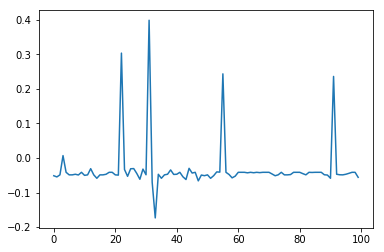

In [134]:
plt.plot(range(len(logits)), logits)
plt.show()